# Do a standard multitask scaffold split
Here we demonstrate ATOM's implementation of a multitask scaffold splitter. This not only separates the scaffolds that are in each subset, but also makes sure to balance the various tasks in a multitask dataset which could be sparse around some scaffolds. For example, the SLC datasets have good overlap but still some unique compounds and 2-set overlaps:
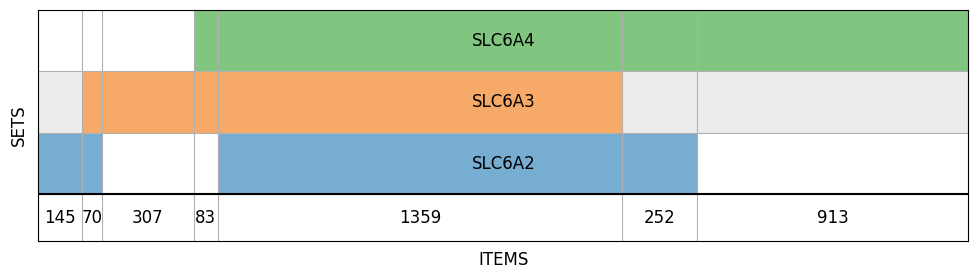

The multitask scaffold splitter is specifically designed to achieve a good balance between dataset response distribution and scaffold splitting for datasets like this. 

> **Note**: *This module can also be used, and is often beneficial, for single-task datasets as well.*

In [62]:
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.split_response_dist_plots as srdp
import atomsci.ddm.utils.split_diagnostic_plots as sdp
import pandas as pd
import atomsci.ddm.utils.compare_splits_plots as csp
from atomsci.ddm.pipeline import diversity_plots as dp
import matplotlib.pyplot as plt
import seaborn as sns

# Set for less chatty log messages
import logging
logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)

In [32]:
splitter = 'multitaskscaffold'
dset_file = '../dataset/SLC6A2_3_4.csv'
params = {
    "dataset_key" : dset_file,
    "splitter": splitter,
    "split_valid_frac": "0.20",
    "split_test_frac": "0.20",
    "split_strategy": "train_valid_test",
    "mtss_train_valid_dist_weight": "1.0",
    "mtss_train_test_dist_weight": "1.0",
    "mtss_split_fraction_weight": "1.0",
    "mtss_response_distr_weight": "0.0",
    "mtss_num_generations": "100",
    "mtss_num_super_scaffolds": "100",
    "previously_split": "False",
    "previously_featurized": "False",
    "prediction_type": "regression",
    "response_cols" : "avg_pKi_SLC6A2,avg_pKi_SLC6A3,avg_pKi_SLC6A4",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": 'dataset/SLC6A2_3_4_models',
    # "model_type": "NN",
    "featurizer": "computed_descriptors",
    "descriptor_type": "rdkit_raw",
    "previously_featurized":"True",
    "learning_rate": ".0005",
    "layer_sizes": "128,64",
    "dropouts": "0.3,0.3",
    "max_epochs": "100",
    "early_stopping_patience": "50",
    "verbose": "True",
}
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
mtss_split_uuid = MP.split_dataset()

INFO:ATOM:Using prefeaturized data; number of features = 200
INFO:ATOM:Splitting data by multitaskscaffold
INFO:ATOM:Duplicate ids or smiles in the dataset, will deduplicate first and assign all records per compound ID to same partition
INFO:ATOM:Requested 100 super scaffolds, produced 107 from 1147 original scaffolds
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
I

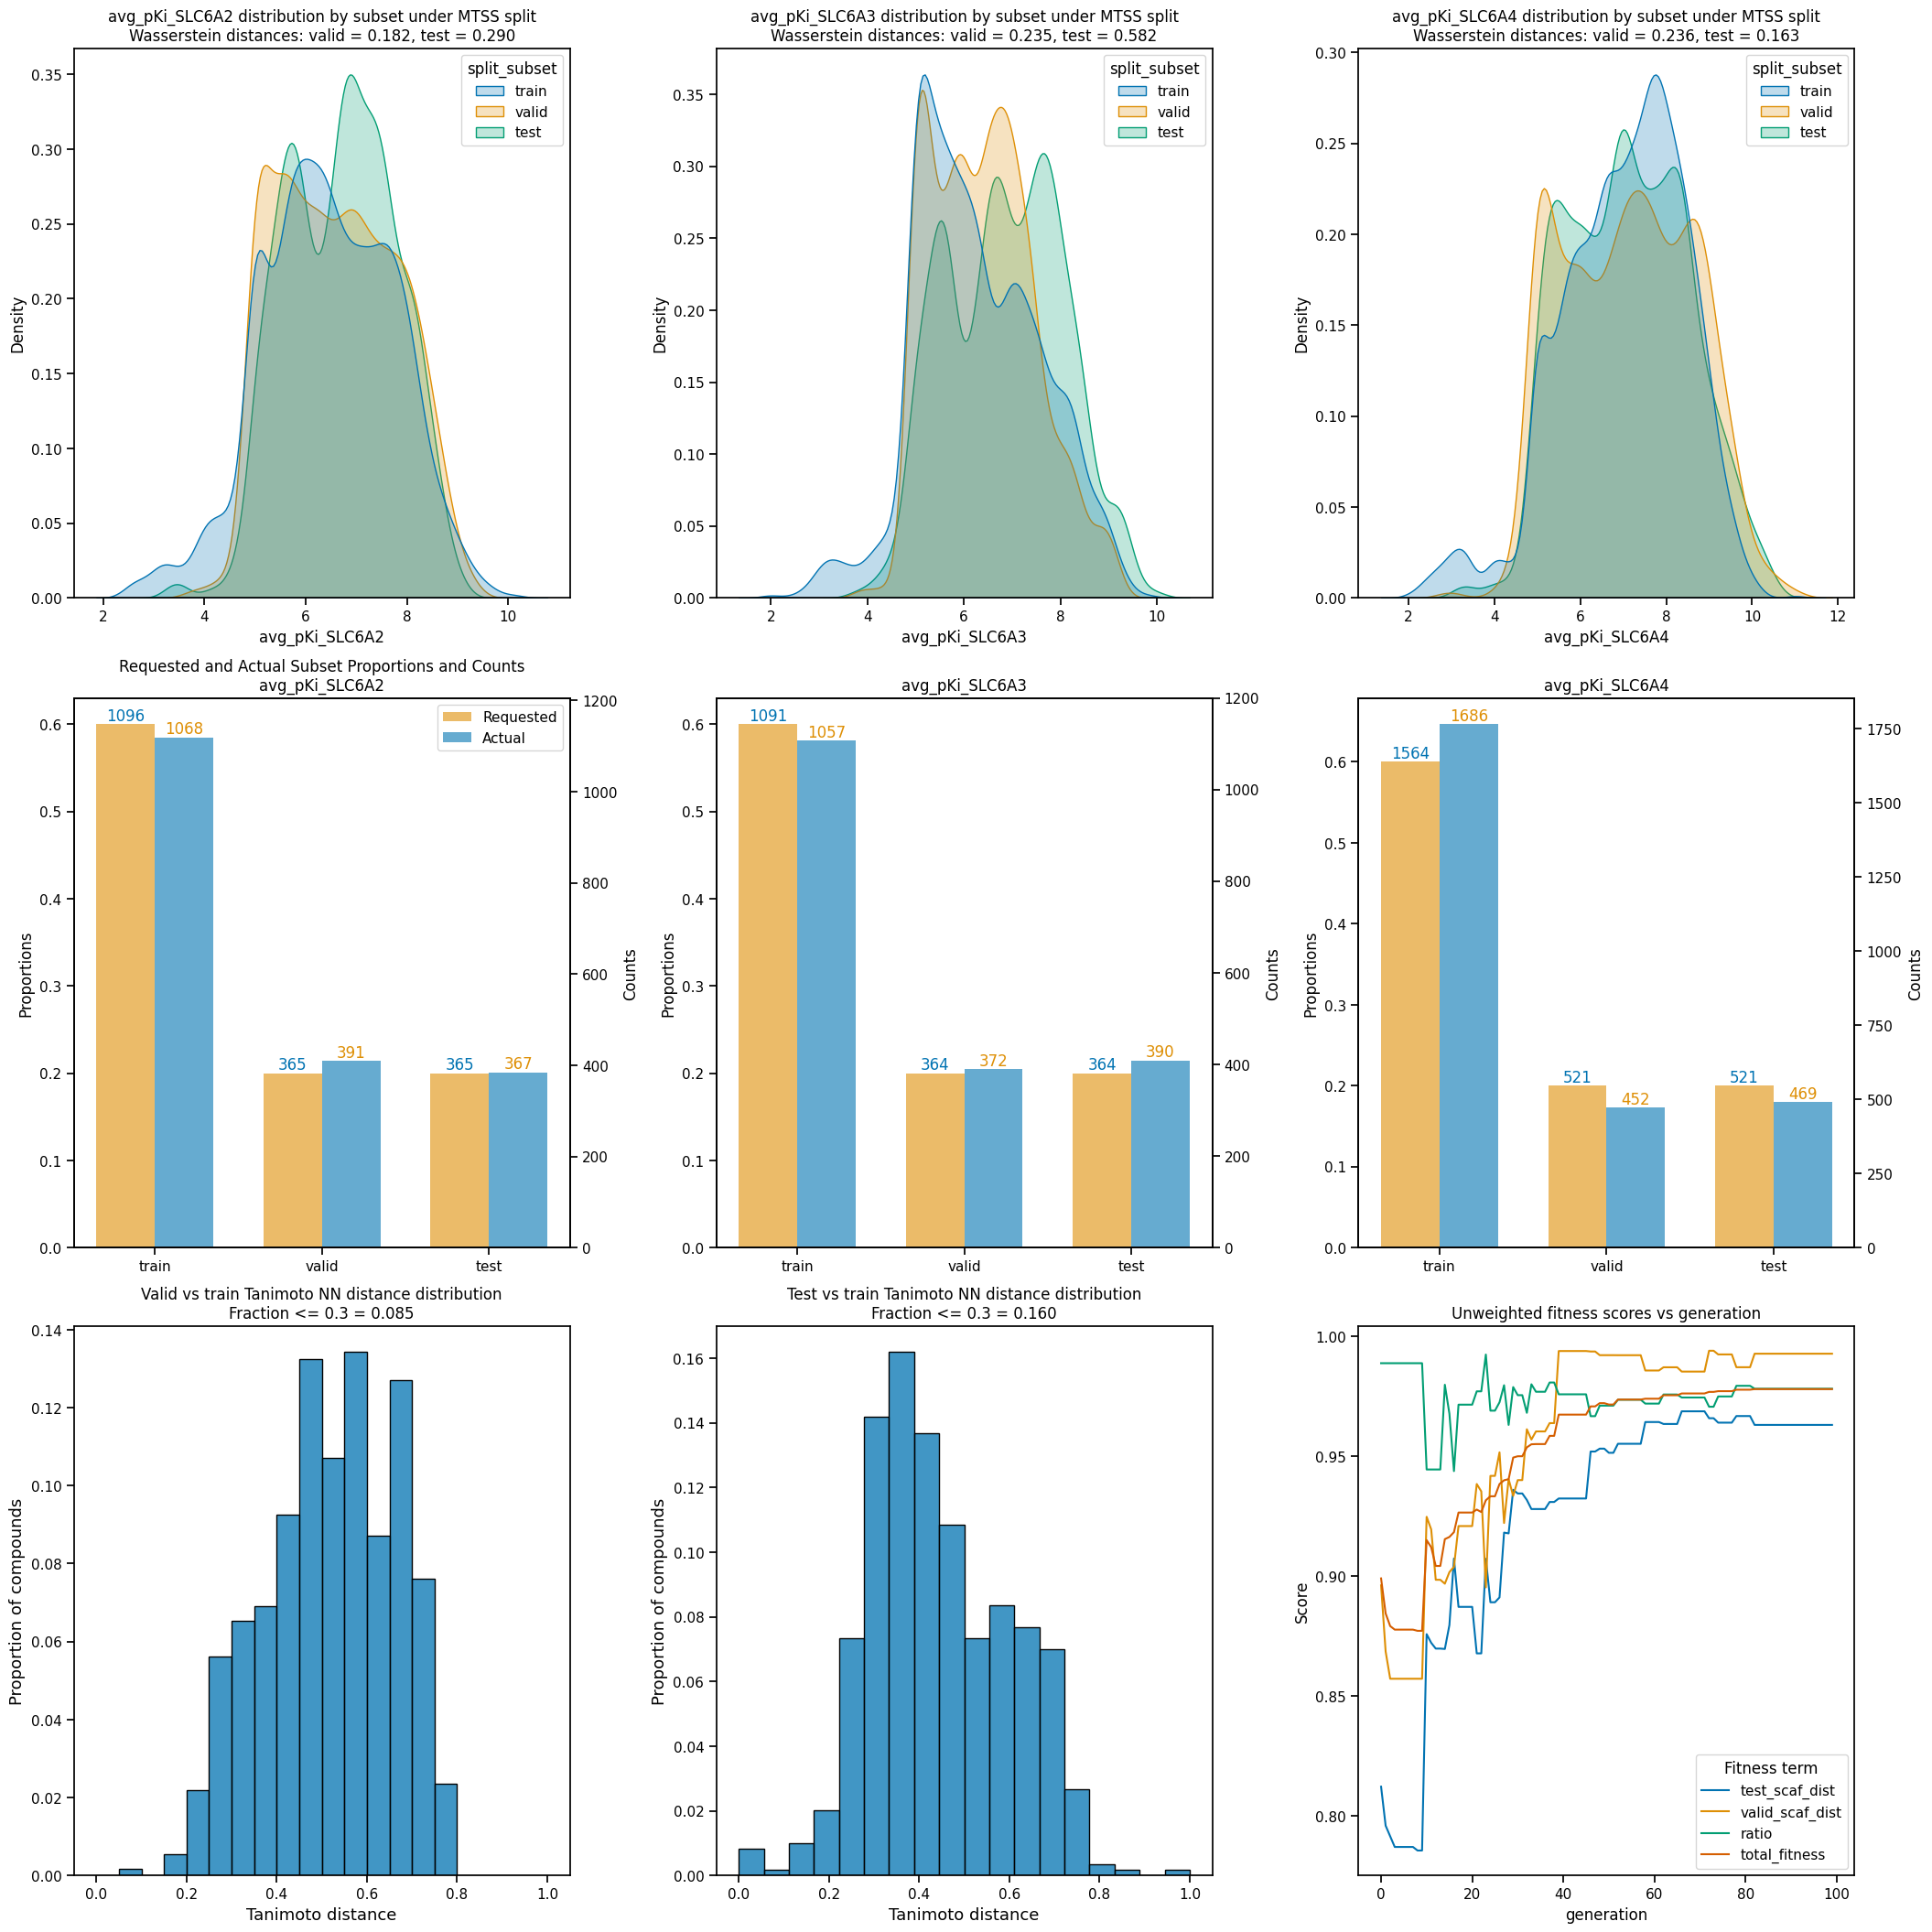

In [35]:
sdp.plot_split_diagnostics(MP, num_cols=3)

In the top row of graphs, the response distributions for each subset and task look alright, but we can probably do better. Let's try increasing the `mtss_response_distr_weight` to 2.0 This will encourage the splitter to try to achieve more equal response distributions compared to scaffold distributions.

In [36]:
splitter = 'multitaskscaffold'
dset_file = '../dataset/SLC6A2_3_4.csv'

params = {
    "dataset_key" : dset_file,
    "splitter": splitter,
    "split_valid_frac": "0.20",
    "split_test_frac": "0.20",
    "split_strategy": "train_valid_test",
    "mtss_train_valid_dist_weight": "1.0",
    "mtss_train_test_dist_weight": "1.0",
    "mtss_split_fraction_weight": "1.0",
    
    "mtss_response_distr_weight": "2.0",
    
    "mtss_num_generations": "100",
    "mtss_num_super_scaffolds": "100",
    "previously_split": "False",
    "previously_featurized": "False",
    "prediction_type": "regression",
    "response_cols" : "avg_pKi_SLC6A2,avg_pKi_SLC6A3,avg_pKi_SLC6A4",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": 'dataset/SLC6A2_3_4_models',
    "model_type": "NN",
    "featurizer": "computed_descriptors",
    "descriptor_type": "rdkit_raw",
    "previously_featurized":"True",
    "learning_rate": ".0005",
    "layer_sizes": "128,64",
    "dropouts": "0.3,0.3",
    "max_epochs": "100",
    "early_stopping_patience": "50",
    "verbose": "True",
}
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
mtss_split_uuid = MP.split_dataset()

INFO:ATOM:Using prefeaturized data; number of features = 200
INFO:ATOM:Splitting data by multitaskscaffold
INFO:ATOM:Duplicate ids or smiles in the dataset, will deduplicate first and assign all records per compound ID to same partition
INFO:ATOM:Requested 100 super scaffolds, produced 107 from 1147 original scaffolds
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
I

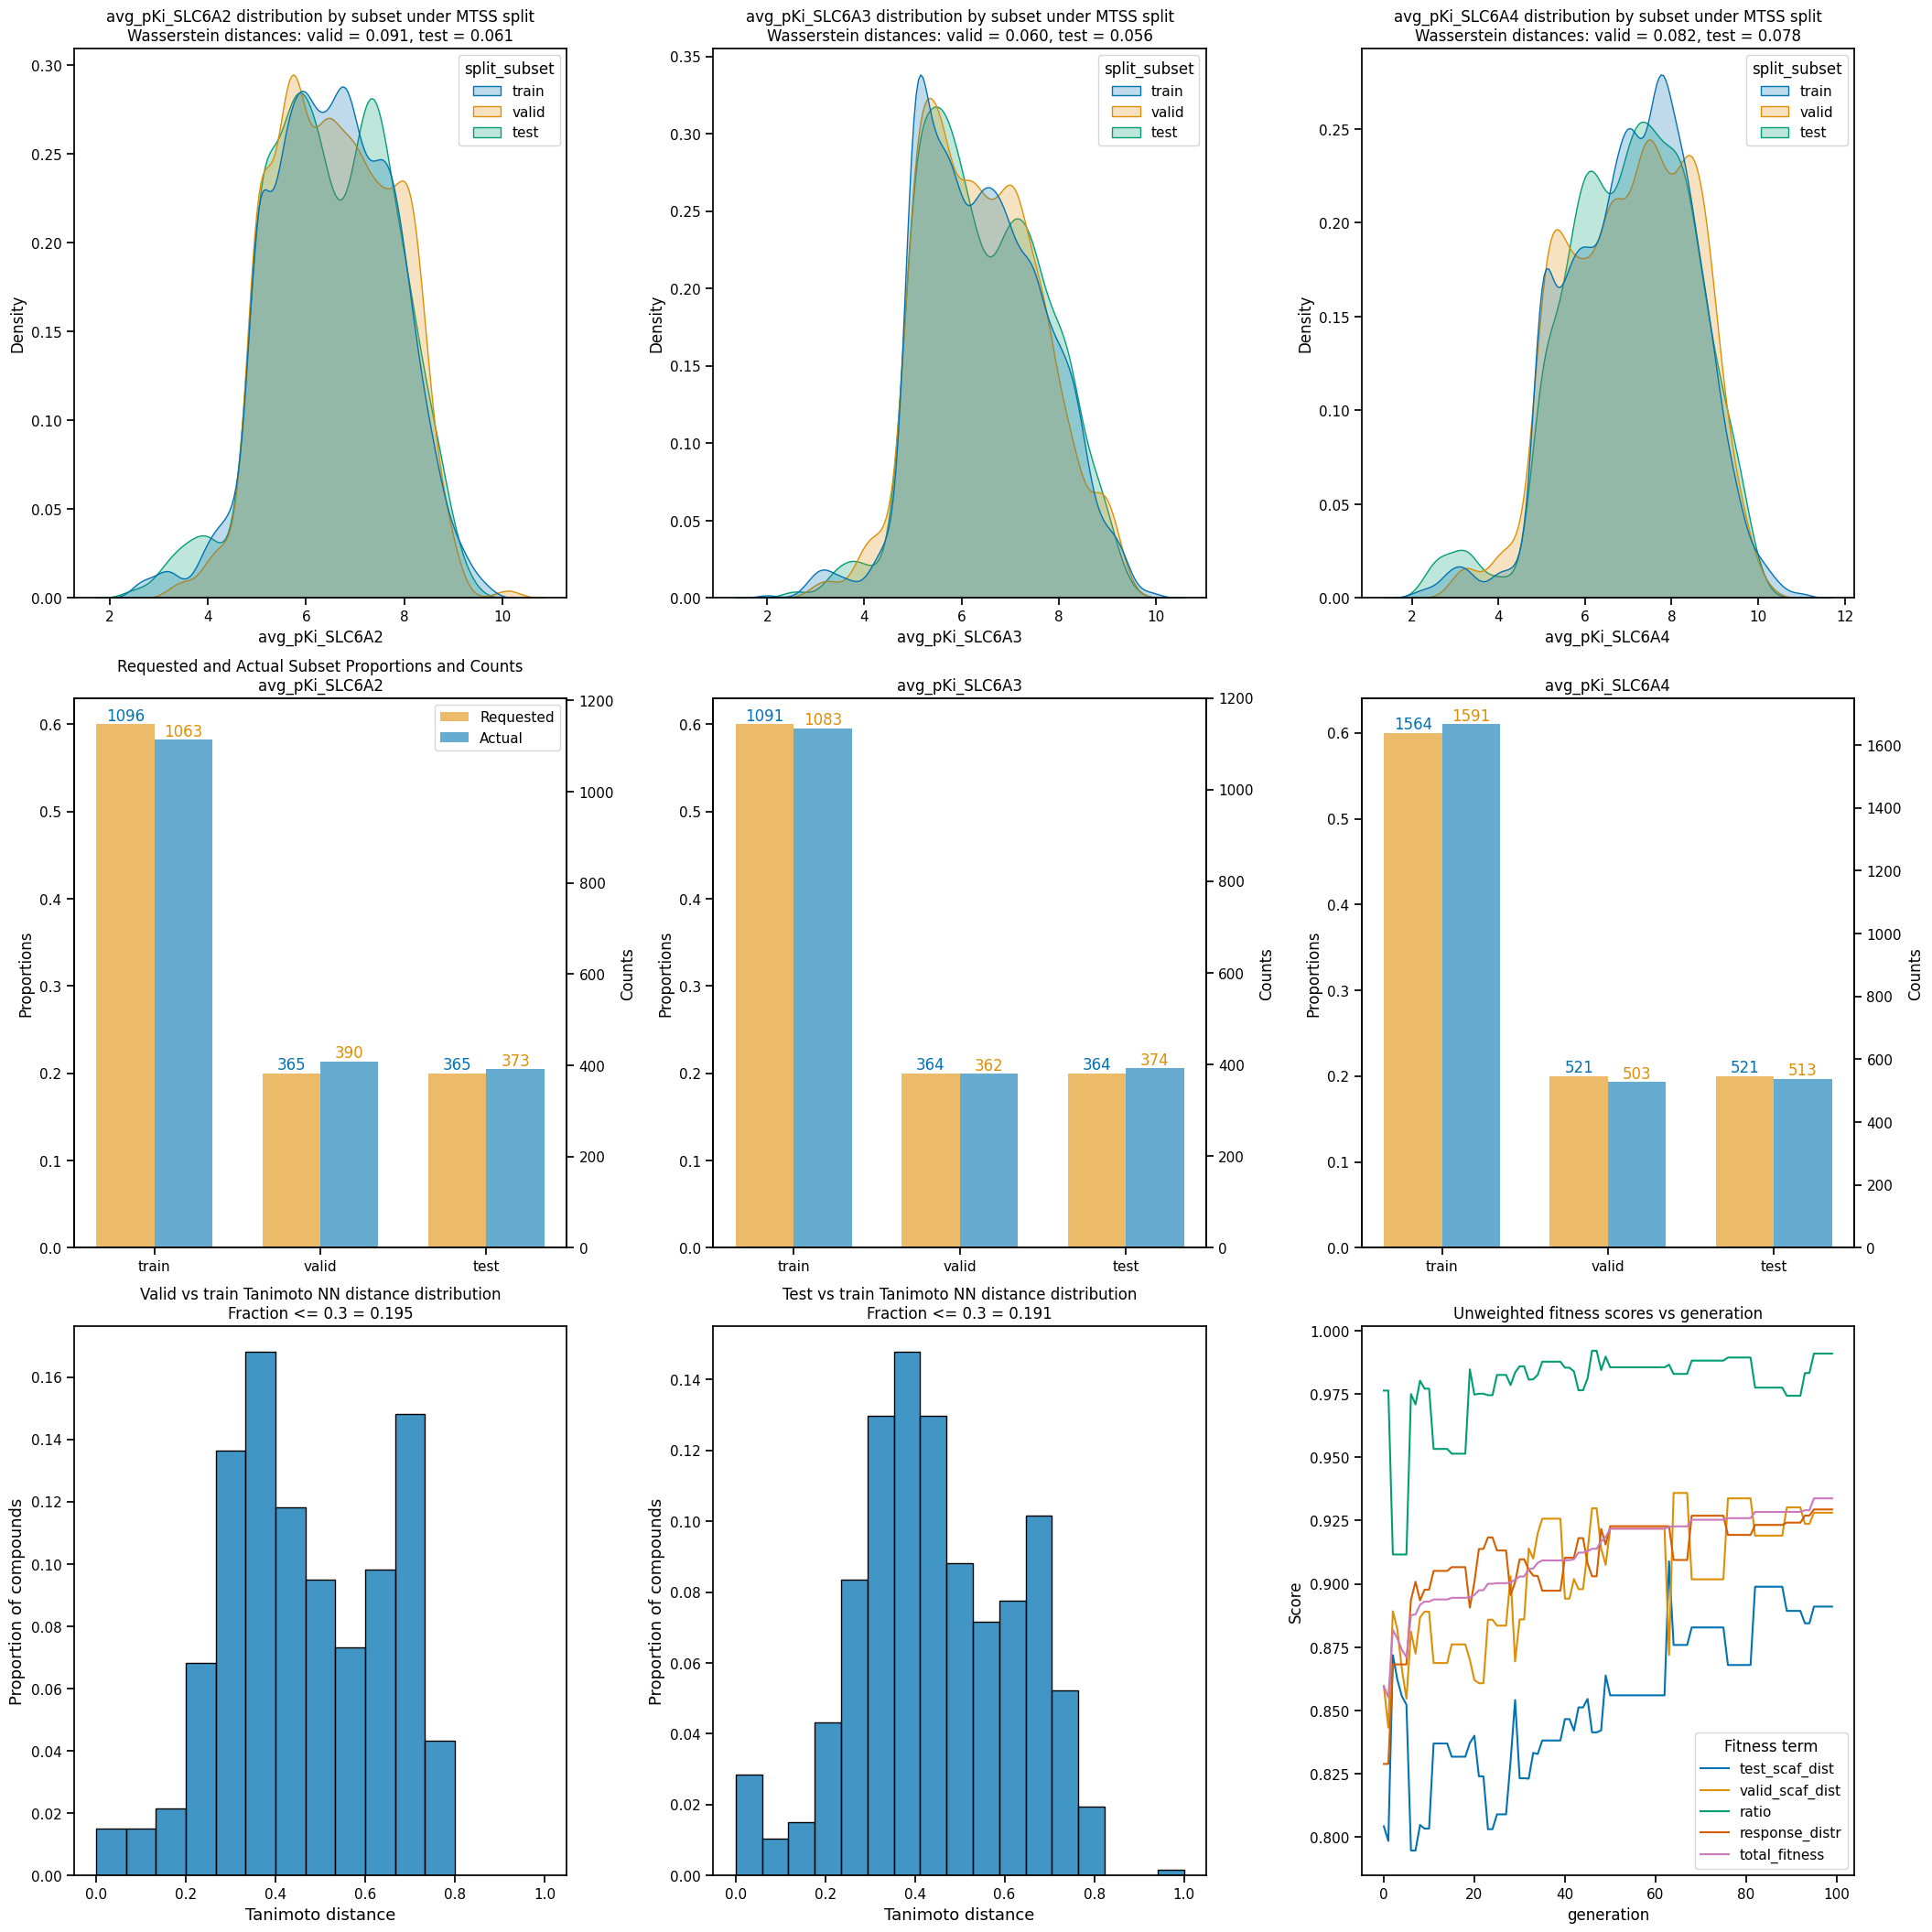

In [39]:
import importlib
importlib.reload(sdp)
sdp.plot_split_diagnostics(MP, num_cols=3)

This split looks pretty good. We can analyze further below.

In [8]:
mtss_split_uuid

'0e7aabc4-ad37-4dca-8e43-0103a30850e7'

## Analyze the tradeoff between response column distribution and tanimoto distance distributions for different split parameters
In any MTSS split, it is always a balance between the distribution of response columns across subsets and the diversity of compounds in each partition when compared to the training set. Here we look more closely at each of these distributions.

### Visualize response column distributions across subsets

In [54]:
mtss_split_uuid_1 = 'f32a4b60-843b-446a-9bff-194875b41581'
mtss_split_uuid_2 = '0e7aabc4-ad37-4dca-8e43-0103a30850e7'

Looking closer at the response distributions between subsets, we want to make sure there is fairly equal distribution of response values across all three subsets so that the model is trained on and predicts on similar data. 

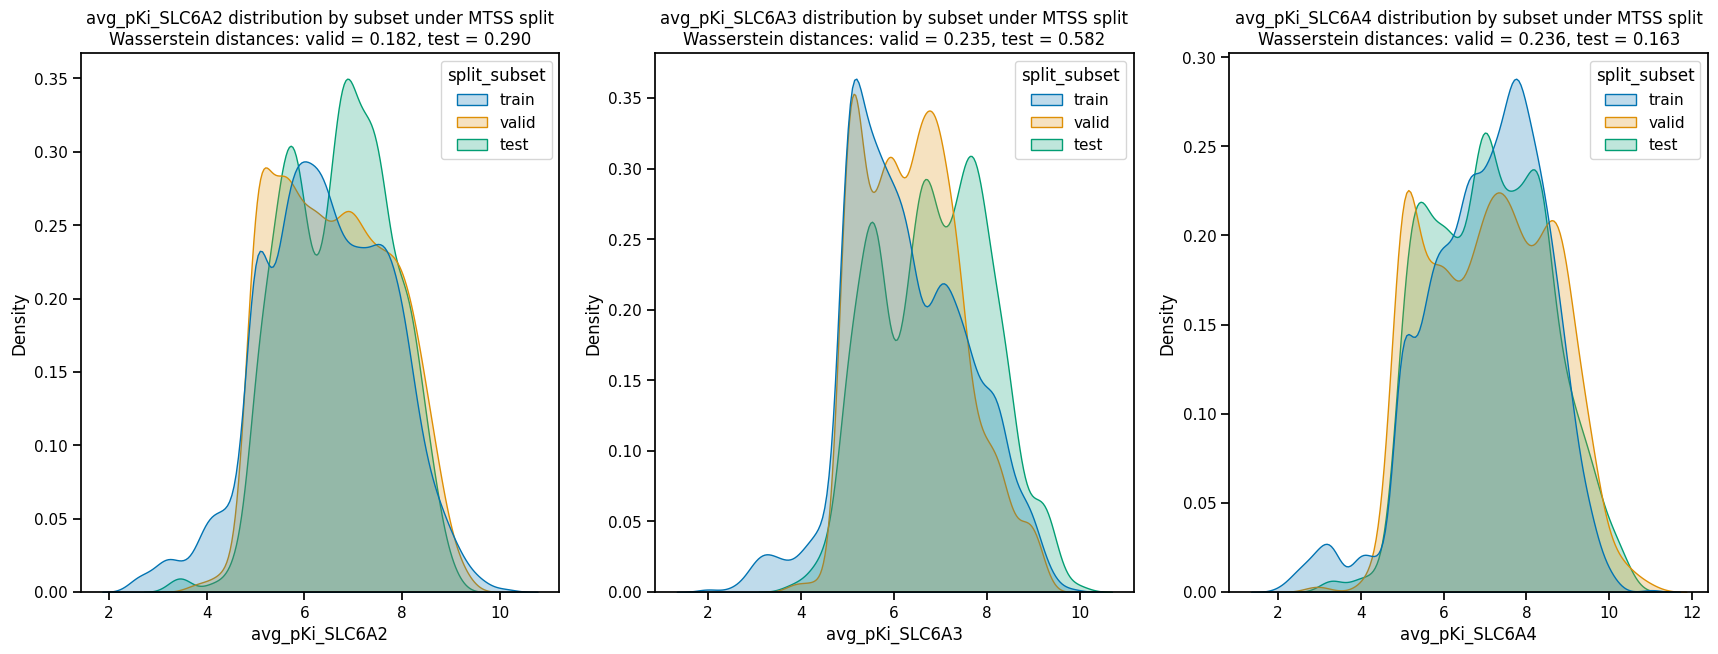

In [55]:
# visualize the uneven distribution
dset_file = '../dataset/SLC6A2_3_4.csv'
splitter = 'multitaskscaffold'
params = {
    "dataset_key" : dset_file,
    "splitter": splitter,
    "split_valid_frac": "0.20",
    "split_test_frac": "0.20",
    "split_strategy": "train_valid_test",
    "split_uuid": mtss_split_uuid_1,
    "response_cols" : "avg_pKi_SLC6A2,avg_pKi_SLC6A3,avg_pKi_SLC6A4",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
}
srdp.plot_split_subset_response_distrs(params)

The [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric) or "earth-moving" distance is the minimum cost to convert the validation or test distribution into the training distribution. You can think of each distribution like a pile of soil and the metric is how much work it would be to create the training "pile shape" from the existing validation or test "pile shape". A higher number would indicate that the distributions are less alike.

In [56]:
srdp.compute_split_subset_wasserstein_distances(params)

,response_col,split_subset,distance
0,avg_pKi_SLC6A2,valid,0.181523
1,avg_pKi_SLC6A2,test,0.289613
2,avg_pKi_SLC6A3,valid,0.235485
3,avg_pKi_SLC6A3,test,0.582292
4,avg_pKi_SLC6A4,valid,0.236057
5,avg_pKi_SLC6A4,test,0.162924


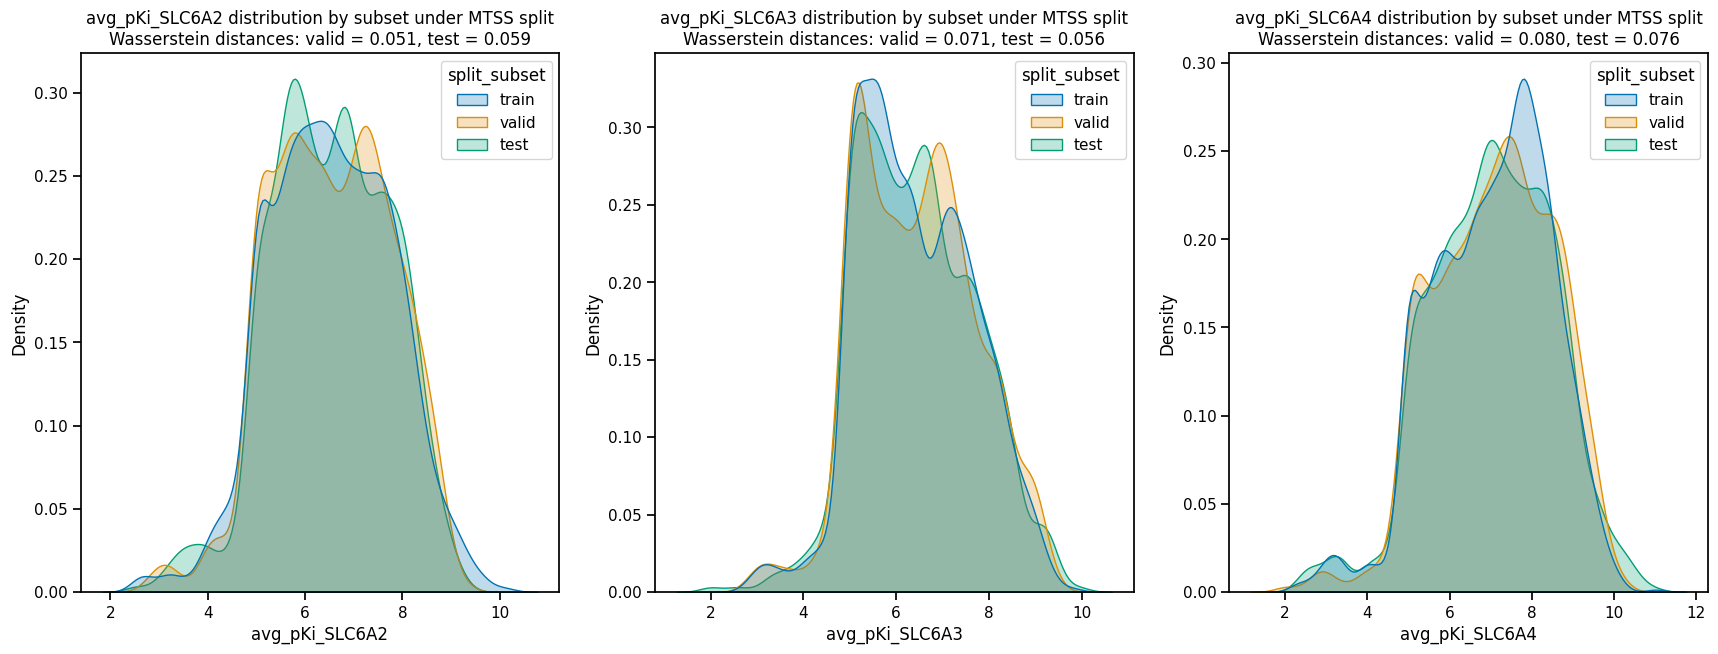

In [57]:
# visualize the more even distribution
dset_file = '../dataset/SLC6A2_3_4.csv'
splitter = 'multitaskscaffold'
params = {
    "dataset_key" : dset_file,
    "splitter": splitter,
    "split_valid_frac": "0.20",
    "split_test_frac": "0.20",
    "split_strategy": "train_valid_test",
    "split_uuid": mtss_split_uuid_2,
    "response_cols" : "avg_pKi_SLC6A2,avg_pKi_SLC6A3,avg_pKi_SLC6A4",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
}
srdp.plot_split_subset_response_distrs(params)

In [58]:
srdp.compute_split_subset_wasserstein_distances(params)

,response_col,split_subset,distance
0,avg_pKi_SLC6A2,valid,0.050816
1,avg_pKi_SLC6A2,test,0.059077
2,avg_pKi_SLC6A3,valid,0.071472
3,avg_pKi_SLC6A3,test,0.056448
4,avg_pKi_SLC6A4,valid,0.079513
5,avg_pKi_SLC6A4,test,0.076472


The Wasserstein distances for split #2 where we increased the `mtss_response_distr_weight` to 2.0 are much lower than for the split #1.

### Visualize tanimoto distance distributions across subsets
When splitting by scaffold, we want to see a higher average Tanimoto distance from any compound in the valid/test sets when compared to its nearest neighbor in the training dataset. In this way, the scaffold split will force the model not to just memorize scaffold structures but instead learn new combinations of features that can help to generalize predictions on never-before-seen scaffolds. To visualize the distribution of Tanimoto distances of compounds to their nearest neighbor in the training dataset we use `diversity_plots.plot_tani_dist_distribution()`. 

In [67]:
# visualize split 1 by merging the dataset smiles with the split subsets
df=pd.read_csv('../dataset/SLC6A2_3_4.csv')
split=pd.read_csv(f'../dataset/SLC6A2_3_4_train_valid_test_multitaskscaffold_{mtss_split_uuid_1}.csv')
split_df=df.merge(split, left_on='compound_id', right_on='cmpd_id')

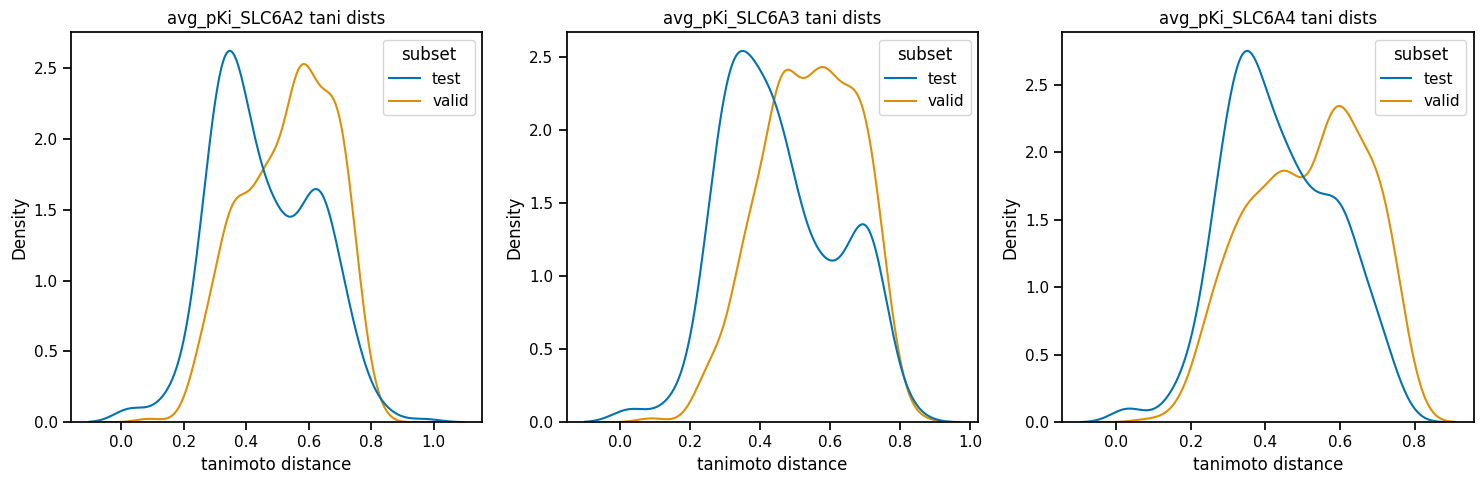

In [68]:
sns.set_context('notebook')
response_cols=["avg_pKi_SLC6A2","avg_pKi_SLC6A3","avg_pKi_SLC6A4",]
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, resp in enumerate(response_cols):
    dp.plot_tani_dist_distr(split_df[split_df[resp].notna()], 'base_rdkit_smiles', resp, radius=4, subsets=True, ax=ax[i])
    ax[i].set_title(f'{resp} tani dists')
fig.tight_layout()

This split looks problematic because the test set compounds have a lower average tanimoto distance to the training set than the validation set compounds. This will result in inflated test set performance metrics and we will not understand how well our model might generalize to new scaffolds. 

In [69]:
# visualize split 2
df=pd.read_csv('../dataset/SLC6A2_3_4.csv')
split=pd.read_csv(f'../dataset/SLC6A2_3_4_train_valid_test_multitaskscaffold_{mtss_split_uuid_2}.csv')
split_df=df.merge(split, left_on='compound_id', right_on='cmpd_id')

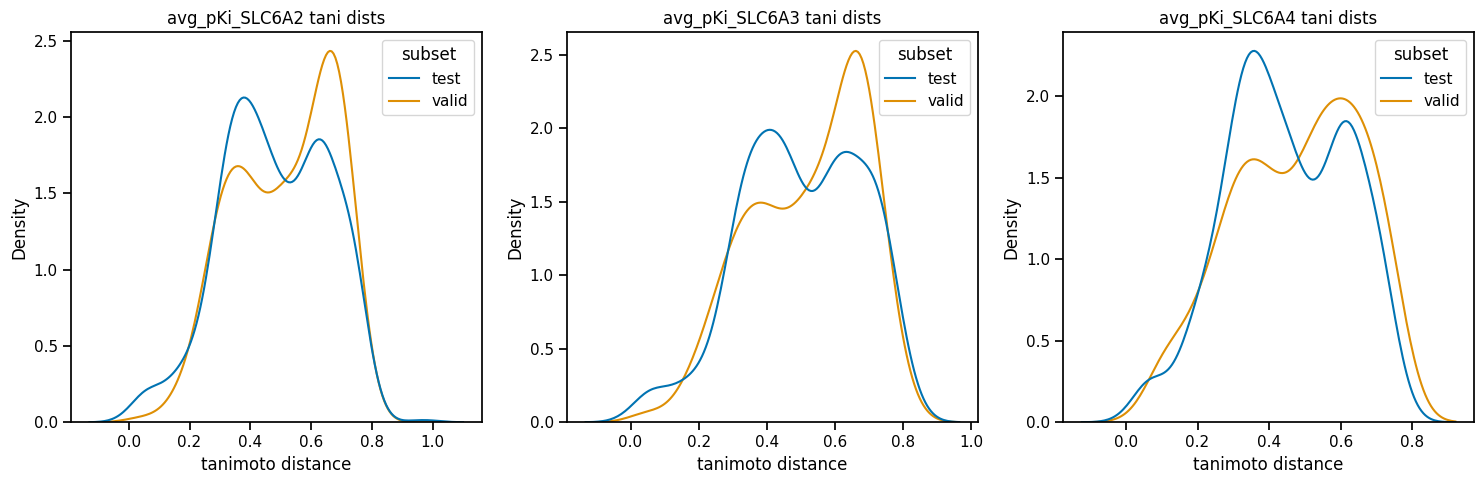

In [70]:
sns.set_context('notebook')
response_cols=["avg_pKi_SLC6A2","avg_pKi_SLC6A3","avg_pKi_SLC6A4",]
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, resp in enumerate(response_cols):
    dp.plot_tani_dist_distr(split_df[split_df[resp].notna()], 'base_rdkit_smiles', resp, radius=4, subsets=True, ax=ax[i])
    ax[i].set_title(f'{resp} tani dists')
fig.tight_layout()

While this split still shows some differences in test and validation set distance distributions, it overall looks more equal, indicating that your test set will be a decent indicator of how well this model does on new data.